In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import spacy

2023-05-04 14:12:02.761987: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-04 14:12:02.763611: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 14:12:02.792374: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-04 14:12:02.792832: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-04 14:12:03.248147: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [2]:
# !python3 -m spacy download fr_core_news_sm
spacy.load('fr_core_news_sm')

In [3]:
nlp = spacy.load("fr_core_news_sm")
from nltk.corpus import stopwords
from nltk import download
download('stopwords')
stopWords = set(stopwords.words('french'))
print(stopWords)

{'fûmes', 'toi', 'étais', 'qui', 'est', 'une', 'se', 'êtes', 'aurez', 'ses', 'le', 'ayantes', 'ait', 'étants', 'avait', 'avaient', 'ayez', 'et', 'étions', 'eue', 'étés', 'fut', 'fût', 'qu', 'avais', 'ma', 'sa', 'serais', 'tes', 'seraient', 'vous', 'était', 'que', 'serions', 'eussions', 'été', 'en', 'vos', 'n', 'mon', 'ton', 'sois', 'étantes', 'leur', 'aurais', 'eût', 'auriez', 'aurait', 'm', 'ai', 'la', 'elle', 'ta', 'des', 'fusse', 'as', 't', 'pour', 'auras', 'ayant', 'même', 'soit', 'son', 'serez', 'j', 'je', 'étées', 'serait', 'avec', 'fusses', 'de', 'par', 'il', 'me', 'eusse', 'eûmes', 'y', 'mais', 'eûtes', 'eues', 'eu', 'aura', 'seriez', 'nous', 'ayants', 'eus', 'lui', 'ne', 'seront', 'étante', 'fus', 'aurons', 'ayante', 'seras', 'eurent', 'ont', 'eux', 'votre', 's', 'serai', 'eussiez', 'étée', 'mes', 'sera', 'aurai', 'fussions', 'eusses', 'es', 'aies', 'notre', 'nos', 'ou', 'aurions', 'pas', 'soient', 'avions', 'fûtes', 'd', 'aient', 'ayons', 'eut', 'étant', 'au', 'auront', 'ce',

[nltk_data] Downloading package stopwords to /home/el0h1m/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# CNN

## Chargement des Données

In [4]:
# Données d'entrainement
train_data_complete = pd.read_csv("../data/allocine_genres_train.csv", sep=",")
train_data = train_data_complete[["titre", "synopsis", "genre"]]

# Données de test/validation
test_data_complete = pd.read_csv("../data/allocine_genres_test.csv", sep=",")
test_data = test_data_complete[["titre", "synopsis", "genre"]]

In [5]:
X = train_data.drop('genre', axis=1)
y = train_data['genre']

# Initialize the RandomOverSampler
ros = RandomOverSampler()
#ros = RandomUnderSampler()


# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
train_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='genre')], axis=1)

Lister les classes et leur associer un identifiant unique. (Utile pour le plongement des mots et pour l'entraînement du CNN).

In [6]:
# Liste des genres
genre_name = sorted(train_data.genre.unique().flatten())
print("Genres:", genre_name)
print("Nombre d'exemplaires:", len(train_data))

# Identifiant unique par genre
genre2id = {genre_name[i]:i for i in range(len(genre_name))}
id2genre = {i:genre_name[i] for i in range(len(genre_name))}

Genres: ['biopic', 'comédie', 'documentaire', 'drame', 'historique', 'horreur', 'policier', 'romance', 'science fiction']
Nombre d'exemplaires: 4509


Remplacer les genres par la valeur numérique associée.

In [7]:
train_data = train_data.replace({"genre": genre2id})
train_data.head()

,titre,synopsis,genre
0,Le Crime de l' Orient - Express,"En visite à Istanbul , le célèbre détective be...",6
1,12 hommes en colère,Un jeune homme d' origine modeste est accusé d...,3
2,Après moi le bonheur,"Lorsque Marie-Laure , mère de quatre jeunes en...",3
3,Les Lumières de la ville,Un vagabond s’ éprend d’ une belle et jeune ve...,7
4,Les Chemins de la dignité,"L' histoire vraie de Carl Brashear , premier A...",0


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_data[["titre", "synopsis"]],
                                                    train_data[["genre"]],
                                                    test_size=0.001,
                                                    random_state=12, # Random seed for shuffle
                                                    shuffle=False)

On combine le titre et le synopsis pour pouvoir les vectoriser par la suite.

In [9]:
X_train_titre = X_train.titre
X_train = X_train_titre + " " + X_train.synopsis

In [10]:
import string

def preprocess(sentence) :
    list_w = nlp(sentence)
    list_w_clean = []
    res = []
    for token in list_w:
        if (token.text.lower() not in stopWords) and (token.text not in string.punctuation):
            list_w_clean.append(token)
    for token in list_w_clean:
        res.append(token.lemma_.lower())
    return " ".join(res)

In [11]:
X_train = X_train.apply(preprocess)

In [12]:
X_train.head()

0    crime orient express visite istanbul célèbre d...
1    12 homme colère jeune homme origine modeste ac...
2    après bonheur lorsque marie-laure mère quatre ...
3    lumière ville vagabond ’ éprendre ’ belle jeun...
4    chemin dignité histoire vrai carl brashear pre...
dtype: object

In [13]:
y_train.head()

,genre
0,6
1,3
2,3
3,7
4,0


In [14]:
print(X_train.shape)
print(X_train)
print(y_train.shape)

(4504,)
0       crime orient express visite istanbul célèbre d...
1       12 homme colère jeune homme origine modeste ac...
2       après bonheur lorsque marie-laure mère quatre ...
3       lumière ville vagabond ’ éprendre ’ belle jeun...
4       chemin dignité histoire vrai carl brashear pre...
                              ...                        
4499    looper futur proche mafia avoir mettre point s...
4500    monde entrer futur proche équipe spatial ’ env...
4501    anon avenir où intimité abolir enquêteur pench...
4502    alita battle angel lorsqu ’ alita réveiller sa...
4503    untitled g.i. joe origins 2 reboot aventure g....
Length: 4504, dtype: object
(4504, 1)


## Indexation du Vocabulaire

In [15]:
def get_vectorizer(documents, max_voc_size=8000, max_seq_length= 200, batch_size=64):
	vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_voc_size, output_sequence_length=max_seq_length)
	# Création du jeu de données à partir de X_train et constitution de lots de 128 instances
	text_ds = tf.data.Dataset.from_tensor_slices(documents).batch(batch_size)
	# Création du vocabulaire à partir des données d'entrée
	vectorizer.adapt(text_ds)
	return vectorizer

In [16]:
keras_vectorizer = get_vectorizer(X_train)

2023-05-04 14:12:59.563014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4504]
	 [[{{node Placeholder/_0}}]]


In [17]:
voc = keras_vectorizer.get_vocabulary()
print(len(voc))

8000


In [18]:
voc[:10]

['', '[UNK]', '’', 'avoir', 'plus', 'tout', 'faire', 'aller', 'vie', 'jeune']

In [19]:
word_index = dict(zip(voc, range(len(voc))))
print(word_index)

{'': 0, '[UNK]': 1, '’': 2, 'avoir': 3, 'plus': 4, 'tout': 5, 'faire': 6, 'aller': 7, 'vie': 8, 'jeune': 9, 'an': 10, 'femme': 11, 'homme': 12, 'ce': 13, 'deux': 14, '…': 15, 'alors': 16, 'pouvoir': 17, 'monde': 18, 'jour': 19, 'nouveau': 20, 'entrer': 21, 'leur': 22, 'histoire': 23, 'où': 24, 'devoir': 25, 'être': 26, 'fille': 27, 'devenir': 28, 'découvrir': 29, 'après': 30, 'retrouver': 31, 'grand': 32, 'petit': 33, 'autre': 34, 'décider': 35, 'famille': 36, 'voir': 37, 'sans': 38, 'année': 39, 'celui': 40, 'prendre': 41, 'comme': 42, 'premier': 43, 'seul': 44, 'ami': 45, 'dernier': 46, 'film': 47, 'amour': 48, 'père': 49, 'temps': 50, 'passer': 51, 'enfant': 52, 'peu': 53, 'dont': 54, 'mettre': 55, 'bien': 56, 'aussi': 57, 'ville': 58, 'mort': 59, 'depuis': 60, 'mère': 61, 'trouver': 62, 'rencontre': 63, 'the': 64, 'guerre': 65, 'quelque': 66, 'sou': 67, 'vivre': 68, 'venir': 69, 'contre': 70, 'quand': 71, 'très': 72, 'jusqu': 73, 'secret': 74, 'fils': 75, 'trois': 76, 'si': 77, 'nu

In [20]:
print("Texte initial:", X_train.iloc[1])
output = keras_vectorizer([X_train.iloc[1]])
print("Vocabulaire dans le texte (15 premiers items):")
for v in output.numpy()[0, :15]:
    print(v, keras_vectorizer.get_vocabulary()[v])

Texte initial: 12 homme colère jeune homme origine modeste accuser meurtre père risque peine mort jury composer douze homme retirer délibérer procéder immédiatement vote onze voter coupable or décision devoir être prendre unanimité juré avoir voter non-coupabl sommé justifier expliquer avoir doute vie homme mérite quelque heure discussion emploie alors convaincre
Vocabulaire dans le texte (15 premiers items):
663 12
12 homme
750 colère
9 jeune
12 homme
303 origine
1016 modeste
876 accuser
210 meurtre
49 père
373 risque
482 peine
59 mort
7331 jury
998 composer


## Chargement de Plongements de Mots Pré-entraînés

In [21]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("../embedding/frWiki_no_phrase_no_postag_700_cbow_cut100.bin", binary=True, unicode_errors="ignore")
model.most_similar("bonjour")

[('merci', 0.7507892847061157),
 ('bonsoir', 0.7450243830680847),
 ('votre', 0.5642200112342834),
 ('vous', 0.5538792014122009),
 ('remercier', 0.5396129488945007),
 ('avance', 0.5288880467414856),
 ('discuter', 0.5033395886421204),
 ('je', 0.49339333176612854),
 ('désoler', 0.4899965822696686),
 ('ici', 0.4887441396713257)]

In [22]:
model.key_to_index

{'</s>': 0,
 'de': 1,
 'la': 2,
 'à': 3,
 'le': 4,
 'et': 5,
 'être': 6,
 'en': 7,
 'les': 8,
 'un': 9,
 'une': 10,
 'avoir': 11,
 'il': 12,
 'dans': 13,
 'par': 14,
 'catégorie': 15,
 'pour': 16,
 'sur': 17,
 'que': 18,
 'se': 19,
 'qui': 20,
 'des': 21,
 'ce': 22,
 'avec': 23,
 'ne': 24,
 'son': 25,
 'an': 26,
 'plus': 27,
 'ou': 28,
 'pas': 29,
 'faire': 30,
 'elle': 31,
 'sa': 32,
 'pouvoir': 33,
 'pop': 34,
 'premier': 35,
 'mais': 36,
 'comme': 37,
 'cette': 38,
 'français': 39,
 'avancement': 40,
 'ses': 41,
 'je': 42,
 'on': 43,
 'deux': 44,
 'france': 45,
 'tout': 46,
 'aussi': 47,
 'lien': 48,
 'grand': 49,
 'année': 50,
 'autre': 51,
 'naissance': 52,
 'article': 53,
 'nom': 54,
 'après': 55,
 'voir': 56,
 'commune': 57,
 'état': 58,
 'ville': 59,
 'externe': 60,
 'y': 61,
 'paris': 62,
 'référence': 63,
 'entre': 64,
 'lui': 65,
 'même': 66,
 'source': 67,
 'sous': 68,
 'jean': 69,
 'lieu': 70,
 'leur': 71,
 'site': 72,
 'note': 73,
 'où': 74,
 'dont': 75,
 'film': 76,
 'ce

In [23]:
model["bonjour"]

array([-4.67579126e-01, -9.34297621e-01, -3.89060646e-01, -2.03962207e-01,
        6.24373436e-01,  5.58501959e-01, -7.94236243e-01,  9.47133780e-01,
       -7.85477459e-01, -4.23343748e-01, -3.78552794e-01,  9.85341787e-01,
       -9.94831264e-01,  7.94630885e-01, -3.72711942e-02, -1.31745422e+00,
       -2.15552300e-01, -1.77847058e-01,  4.44615424e-01,  2.40859807e-01,
       -1.34950832e-01,  2.62641966e-01,  7.27709755e-02, -4.39429581e-01,
        3.13311636e-01,  4.89237309e-01, -3.47837150e-01,  6.98559701e-01,
        3.06835920e-01,  8.79080057e-01, -5.81417084e-01, -3.37294281e-01,
        1.81973651e-01,  7.02408612e-01,  7.81347573e-01,  5.16828001e-01,
        2.21238777e-01, -4.01979834e-01, -3.04546077e-02,  5.94205201e-01,
        7.80208051e-01, -4.02492434e-01,  1.09107220e+00,  1.95819825e-01,
        1.20070234e-01,  4.59087253e-01,  6.24428272e-01,  3.55202556e-02,
       -1.29575109e+00, -5.80421746e-01,  4.97552425e-01,  3.83994550e-01,
       -6.25843883e-01,  

Le plongement pré-entrainé est de dimension 700.

In [24]:
len(model["bonjour"])

700

In [25]:
def load_embeddings(embeddings_model):
    embeddings_index = {}
    for word in list(embeddings_model.key_to_index.keys()):
        embeddings_index[word] = embeddings_model[word]
    print(f'{len(embeddings_index)} vecteurs de mots ont été lus')
    return embeddings_index

In [26]:
embeddings = load_embeddings(model)

39392 vecteurs de mots ont été lus


La cellule suivante permet de créer une matrice de plongements: une matrice où la ligne i correspond au plongement pré-entraîné pour le mot d'indice i dans le vocabulaire.

In [27]:
def get_embedding_matrix(vocabulary, embeddings_index, embedding_dim = 700):
  num_tokens = len(vocabulary)
  hits = 0
  misses = 0

  # Préparation de la matrice
  # Les mots qui ne se trouvent pas dans les plongements pré-entraînés seront 
  # représentés par des vecteurs dont toutes les composantes sont égales à 0,
  # y compris la représentation utilisée pour compléter les documents courts et
  # celle utilisée pour les mots inconnus [UNK]
  embedding_matrix = np.zeros((num_tokens, embedding_dim))
  for word, i in word_index.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_matrix[i] = embedding_vector
          hits += 1
      else:
          misses += 1
  print(f'{hits} mots ont été trouvés dans les plongements pré-entraînés')
  print(f'{misses} sont absents')
  return embedding_matrix

In [28]:
# Construction de la matrice de plongements à partir du vocabulaire
embedding_matrix = get_embedding_matrix(voc, embeddings)

6059 mots ont été trouvés dans les plongements pré-entraînés
1941 sont absents


## Construction du CNN

In [29]:
from tensorflow.keras.layers import Embedding

def get_CNN_model(voc_size, embedding_matrix, embedding_dim=700):
  # Création du modèle
  int_sequences_input = tf.keras.Input(shape=(None,), dtype="int64")
  embedding_layer = Embedding(voc_size, embedding_dim, trainable=True,
      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
  )
  
  embedded_sequences = embedding_layer(int_sequences_input)
  x = tf.keras.layers.Conv1D(64, 5, activation="relu")(embedded_sequences)
  x = tf.keras.layers.MaxPooling1D(5)(x)
  x = tf.keras.layers.Conv1D(64, 5, activation="relu")(x)
  x = tf.keras.layers.GlobalMaxPooling1D()(x)
  x = tf.keras.layers.Dense(64, activation="relu")(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  preds = tf.keras.layers.Dense(len(genre_name), activation="softmax")(x)
  model = tf.keras.Model(int_sequences_input, preds)
  return model

In [50]:
# Affichage de l'architecture du modèle
CNN_model = get_CNN_model(len(voc), embedding_matrix)
CNN_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_6 (Embedding)     (None, None, 700)         5600000   
                                                                 
 conv1d_12 (Conv1D)          (None, None, 64)          224064    
                                                                 
 max_pooling1d_6 (MaxPooling  (None, None, 64)         0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, None, 64)          20544     
                                                                 
 global_max_pooling1d_6 (Glo  (None, 64)               0         
 balMaxPooling1D)                                          

## Entraînement du CNN

In [31]:
from sklearn import model_selection
from tensorflow.keras.callbacks import EarlyStopping # Early stopping to avoid over-fitting

# Fonction pour l'entraînement d'un modèle
def train_model(X, y, model_function, vectorizer, voc_size, embedding_matrix, embedding_dim=700, batch_size=64):
    
    # Early stopping callback
    early_stopping_callback = EarlyStopping(monitor="val_acc", restore_best_weights=True, patience=3)
    
    # Listes utilisées pour sauvegarder les résultats obtenus à chaque pli
    acc_per_fold = []
    loss_per_fold = []
    histories = []
    folds =  5 # 3
    stratkfold = model_selection.StratifiedKFold(n_splits=folds, shuffle=True, random_state=12)
    fold_no = 1
    for train, test in stratkfold.split(X, y):
        m_function = globals()[model_function]
        model = m_function(voc_size, embedding_matrix, embedding_dim)

        print('------------------------------------------------------------------------')
        print(f'Entraînement pour le pli {fold_no} ...')
        fold_x_train = vectorizer(X.iloc[train].to_numpy()).numpy()
        fold_x_val = vectorizer(X.iloc[test].to_numpy()).numpy()
        fold_y_train = y.iloc[train].to_numpy()
        fold_y_val = y.iloc[test].to_numpy()

        # Compilation du modèle : permet de préciser la fonction de perte et l'optimiseur
        # loss=sparse_categorical_crossentropy : entropie croisée, dans le cas où les 
        # classes cibles sont indiquées sous forme d'entiers. Il s'agira de minimiser
        # la perte pendant l'apprentissage
        # optimizer=rmsprop : l'optimiseur détermine la manière doit les poids seront
        # mis à jour pendant l'apprentissage
        model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
        # Entraînement sur 10 époque (la totalité du jeu de données est parcourue
        # 10 fois)
        history = model.fit(fold_x_train, fold_y_train, batch_size=batch_size, epochs=25, validation_data=(fold_x_val, fold_y_val), callbacks=[early_stopping_callback])
        histories.append(history)
        # Evaluation sur les données de validation
        scores = model.evaluate(fold_x_val, fold_y_val, verbose=0)
        print(f'Scores pour le pli {fold_no}: {model.metrics_names[0]} = {scores[0]:.2f};',
            f'{model.metrics_names[1]} = {scores[1]*100:.2f}%')
        acc_per_fold.append(scores[1] * 100)
        loss_per_fold.append(scores[0])
        fold_no = fold_no + 1

    # Affichage des scores moyens par pli
    print('---------------------------------------------------------------------')
    print('Scores par pli')
    for i in range(0, len(acc_per_fold)):
        print('---------------------------------------------------------------------')
        print(f'> Pli {i+1} - Loss: {loss_per_fold[i]:.2f}', f'- Accuracy: {acc_per_fold[i]:.2f}%')
    print('---------------------------------------------------------------------')
    print('Scores moyens pour tous les plis :')
    print(f'> Accuracy: {np.mean(acc_per_fold):.2f}', f'(+- {np.std(acc_per_fold):.2f})')
    print(f'> Loss: {np.mean(loss_per_fold):.2f}')
    print('---------------------------------------------------------------------')
    return histories

In [32]:
# Entraînement du modèle et récupération des résultats
CNN_histories = train_model(X_train, y_train, 'get_CNN_model', keras_vectorizer, len(voc), embedding_matrix)

------------------------------------------------------------------------
Entraînement pour le pli 1 ...
Epoch 1/25
57/57 [==============================] - 5s 82ms/step - loss: 1.9917 - acc: 0.2667 - val_loss: 1.5242 - val_acc: 0.4994
Epoch 2/25
57/57 [==============================] - 5s 91ms/step - loss: 1.2878 - acc: 0.5645 - val_loss: 1.0946 - val_acc: 0.6426
Epoch 3/25
57/57 [==============================] - 5s 89ms/step - loss: 0.8495 - acc: 0.7133 - val_loss: 0.8368 - val_acc: 0.7414
Epoch 4/25
57/57 [==============================] - 5s 88ms/step - loss: 0.5689 - acc: 0.8188 - val_loss: 0.8629 - val_acc: 0.6837
Epoch 5/25
57/57 [==============================] - 5s 89ms/step - loss: 0.3852 - acc: 0.8829 - val_loss: 0.7769 - val_acc: 0.7225
Epoch 6/25
57/57 [==============================] - 5s 91ms/step - loss: 0.2606 - acc: 0.9270 - val_loss: 0.9270 - val_acc: 0.7026
Scores pour le pli 1: loss = 0.84; acc = 74.14%
--------------------------------------------------------------

In [33]:
import seaborn as sns
sns.set_theme(style="darkgrid")

def plot_results(histories):
    accuracy_data = []
    loss_data = []
    for i, h in enumerate(histories):
        acc = h.history['acc']
        val_acc = h.history['val_acc']
        loss = h.history['loss']
        val_loss = h.history['val_loss']
        for j in range(len(acc)):
            accuracy_data.append([i+1, j+1, acc[j], 'Entraînement'])
            accuracy_data.append([i+1, j+1, val_acc[j], 'Validation'])
            loss_data.append([i+1, j+1, loss[j], 'Entraînement'])
            loss_data.append([i+1, j+1, val_loss[j], 'Validation'])

    acc_df = pd.DataFrame(accuracy_data, columns=['Pli', 'Epoch', 'Accuracy', 'Données'])
    sns.relplot(data=acc_df, x='Epoch', y='Accuracy', hue='Pli', style='Données', kind='line')
    
    loss_df = pd.DataFrame(loss_data, columns=['Pli', 'Epoch', 'Perte', 'Données'])
    sns.relplot(data=loss_df, x='Epoch', y='Perte', hue='Pli', style='Données', kind='line')

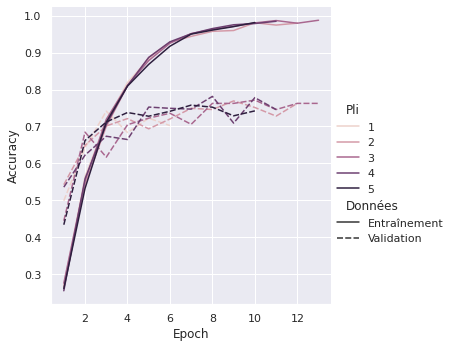

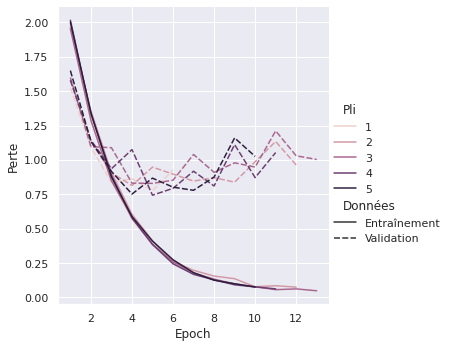

In [34]:
plot_results(CNN_histories)

## Test du Modèle

In [35]:
# Données d'entrainement
train_data_complete = pd.read_csv("../data/allocine_genres_train.csv", sep=",")
train_data = train_data_complete[["titre", "synopsis", "genre"]]

# Données de test/validation
test_data_complete = pd.read_csv("../data/allocine_genres_test.csv", sep=",")
test_data = test_data_complete[["titre", "synopsis", "genre"]]

In [36]:
X = train_data.drop('genre', axis=1)
y = train_data['genre']

# Initialize the RandomOverSampler
ros = RandomOverSampler()
#ros = RandomUnderSampler()


# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)

# Convert the resampled data back to a DataFrame
train_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.Series(y_resampled, name='genre')], axis=1)

In [37]:
# Liste des genres
genre_name = sorted(train_data.genre.unique().flatten())
print("Genres:", genre_name)
print("Nombre d'exemplaires:", len(train_data))

# Identifiant unique par genre
genre2id = {genre_name[i]:i for i in range(len(genre_name))}
id2genre = {i:genre_name[i] for i in range(len(genre_name))}

train_data = train_data.replace({"genre": genre2id})
test_data = test_data.replace({"genre": genre2id})

Genres: ['biopic', 'comédie', 'documentaire', 'drame', 'historique', 'horreur', 'policier', 'romance', 'science fiction']
Nombre d'exemplaires: 4509


In [38]:
X_train_titre = train_data.titre
X_train = X_train_titre + " " + train_data.synopsis
for i in range(len(X_train)):
    X_train[i] = preprocess(X_train[i])
y_train = train_data.genre
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.15,shuffle=True)
X_train = keras_vectorizer(X_train)
X_val = keras_vectorizer(X_val)



X_test_titre = test_data.titre
X_test = X_test_titre + " " + test_data.synopsis
for i in range(len(X_test)):
    X_test[i] = preprocess(X_test[i])
X_test = keras_vectorizer(X_test)
y_test = test_data.genre

In [51]:
# Compile and train model
early_stopping_callback = EarlyStopping(monitor="val_acc", restore_best_weights=True, patience=3)
CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])
CNN_model.fit(X_train, y_train, validation_split=0.1, batch_size=64, epochs=25, callbacks=[early_stopping_callback], validation_data=(X_val,y_val), shuffle=True)

Epoch 1/25
60/60 [==============================] - 5s 74ms/step - loss: 1.9799 - acc: 0.2782 - val_loss: 1.5589 - val_acc: 0.5273
Epoch 2/25
60/60 [==============================] - 4s 73ms/step - loss: 1.2639 - acc: 0.5796 - val_loss: 1.0424 - val_acc: 0.6809
Epoch 3/25
60/60 [==============================] - 4s 74ms/step - loss: 0.8010 - acc: 0.7356 - val_loss: 0.8832 - val_acc: 0.7031
Epoch 4/25
60/60 [==============================] - 5s 75ms/step - loss: 0.5335 - acc: 0.8299 - val_loss: 0.7497 - val_acc: 0.7651
Epoch 5/25
60/60 [==============================] - 5s 90ms/step - loss: 0.3559 - acc: 0.8917 - val_loss: 0.7336 - val_acc: 0.7622
Epoch 6/25
60/60 [==============================] - 5s 90ms/step - loss: 0.2416 - acc: 0.9282 - val_loss: 0.7905 - val_acc: 0.7725
Epoch 7/25
60/60 [==============================] - 5s 91ms/step - loss: 0.1498 - acc: 0.9593 - val_loss: 0.8356 - val_acc: 0.7710
Epoch 8/25
60/60 [==============================] - 5s 89ms/step - loss: 0.1297 - a

In [53]:
# Save model
#CNN_model.save("model")

2023-05-04 14:23:08.525550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]
2023-05-04 14:23:14.500998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,64]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [40]:
# Load saved model
#CNN_model = tf.keras.models.load_model("model")

In [52]:
results = CNN_model.evaluate(X_test, y_test, batch_size=64)
print("test loss, test acc:", results)

12/12 [==============================] - 0s 24ms/step - loss: 1.6458 - acc: 0.4910
test loss, test acc: [1.6458252668380737, 0.49095967411994934]


In [42]:
# Vector of probability for each class
y_pred = CNN_model.predict(X_test)
print(y_pred[0])

# Vector of genre id with the highest probabillity
y_pred = np.argmax(y_pred, axis=1)
print(y_pred[0])

# Convert to dataframe
y_pred = pd.DataFrame(y_pred)

# Rename column and replace genre ids with genre names
y_pred.rename(columns={y_pred.columns[0]: "predicted_genre"}, inplace=True)
y_pred.replace({"predicted_genre": id2genre}, inplace=True)
y_pred

23/23 [==============================] - 0s 16ms/step
[1.0977769e-03 1.4589864e-01 3.6237652e-05 8.0243772e-01 7.6852000e-04
 2.0511700e-03 2.5801808e-03 2.5033319e-02 2.0096462e-02]
3


,predicted_genre
0,drame
1,science fiction
2,drame
3,drame
4,science fiction
...,...
714,comédie
715,comédie
716,science fiction
717,biopic


In [43]:
test_data_complete["predicted_genre"] = y_pred
test_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                719 non-null    int64  
 1   acteur_1                  719 non-null    object 
 2   acteur_2                  691 non-null    object 
 3   acteur_3                  686 non-null    object 
 4   allocine_id               719 non-null    int64  
 5   annee_prod                719 non-null    int64  
 6   annee_sortie              672 non-null    float64
 7   box_office_fr             438 non-null    float64
 8   couleur                   673 non-null    object 
 9   duree                     706 non-null    float64
 10  langues                   591 non-null    object 
 11  nationalite               719 non-null    object 
 12  nb_critiques_presse       514 non-null    float64
 13  nb_critiques_spectateurs  688 non-null    float64
 14  nb_notes_s

In [44]:
test_data_complete.to_csv("../data/test_results.csv")

In [45]:
print(len(test_data_complete[test_data_complete["genre"] == test_data_complete["predicted_genre"]]))

353


In [46]:
# Vector of probability for each class
y_pred = CNN_model.predict(X_test)
print(y_pred.shape)
print(y_pred[0])

# Vector of genre id with the highest probabillity
y_pred = np.argsort(y_pred, axis=1)
print(y_pred[0])
y_pred = np.flip(y_pred, axis=1)
print(y_pred.shape)
print(y_pred[0])

# Convert to dataframe
y_pred = pd.DataFrame(y_pred)

# Rename column and replace genre ids with genre names
y_pred.rename(columns={y_pred.columns[0]: "predicted_genre_1"}, inplace=True)
y_pred.replace({"predicted_genre_1": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[1]: "predicted_genre_2"}, inplace=True)
y_pred.replace({"predicted_genre_2": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[2]: "predicted_genre_3"}, inplace=True)
y_pred.replace({"predicted_genre_3": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[3]: "predicted_genre_4"}, inplace=True)
y_pred.replace({"predicted_genre_4": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[4]: "predicted_genre_5"}, inplace=True)
y_pred.replace({"predicted_genre_5": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[5]: "predicted_genre_6"}, inplace=True)
y_pred.replace({"predicted_genre_6": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[6]: "predicted_genre_7"}, inplace=True)
y_pred.replace({"predicted_genre_7": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[7]: "predicted_genre_8"}, inplace=True)
y_pred.replace({"predicted_genre_8": id2genre}, inplace=True)
y_pred.rename(columns={y_pred.columns[8]: "predicted_genre_9"}, inplace=True)
y_pred.replace({"predicted_genre_9": id2genre}, inplace=True)
y_pred

23/23 [==============================] - 0s 16ms/step
(719, 9)
[1.0977769e-03 1.4589864e-01 3.6237652e-05 8.0243772e-01 7.6852000e-04
 2.0511700e-03 2.5801808e-03 2.5033319e-02 2.0096462e-02]
[2 4 0 5 6 8 7 1 3]
(719, 9)
[3 1 7 8 6 5 0 4 2]


,predicted_genre_1,predicted_genre_2,predicted_genre_3,predicted_genre_4,predicted_genre_5,predicted_genre_6,predicted_genre_7,predicted_genre_8,predicted_genre_9
0,drame,comédie,romance,science fiction,policier,horreur,biopic,historique,documentaire
1,science fiction,historique,horreur,policier,comédie,biopic,romance,drame,documentaire
2,drame,romance,comédie,biopic,policier,science fiction,horreur,historique,documentaire
3,drame,romance,comédie,horreur,policier,science fiction,biopic,documentaire,historique
4,science fiction,drame,historique,horreur,romance,policier,comédie,biopic,documentaire
...,...,...,...,...,...,...,...,...,...
714,comédie,science fiction,drame,historique,romance,biopic,documentaire,horreur,policier
715,comédie,drame,romance,biopic,policier,historique,science fiction,documentaire,horreur
716,science fiction,horreur,historique,comédie,romance,policier,documentaire,drame,biopic
717,biopic,comédie,romance,drame,historique,policier,horreur,documentaire,science fiction


In [47]:
test_data_complete["predicted_genre_1"] = y_pred["predicted_genre_1"]
test_data_complete["predicted_genre_2"] = y_pred["predicted_genre_2"]
test_data_complete["predicted_genre_3"] = y_pred["predicted_genre_3"]
test_data_complete["predicted_genre_4"] = y_pred["predicted_genre_4"]
test_data_complete["predicted_genre_5"] = y_pred["predicted_genre_5"]
test_data_complete["predicted_genre_6"] = y_pred["predicted_genre_6"]
test_data_complete["predicted_genre_7"] = y_pred["predicted_genre_7"]
test_data_complete["predicted_genre_8"] = y_pred["predicted_genre_8"]
test_data_complete["predicted_genre_9"] = y_pred["predicted_genre_9"]

In [48]:
test_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719 entries, 0 to 718
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                719 non-null    int64  
 1   acteur_1                  719 non-null    object 
 2   acteur_2                  691 non-null    object 
 3   acteur_3                  686 non-null    object 
 4   allocine_id               719 non-null    int64  
 5   annee_prod                719 non-null    int64  
 6   annee_sortie              672 non-null    float64
 7   box_office_fr             438 non-null    float64
 8   couleur                   673 non-null    object 
 9   duree                     706 non-null    float64
 10  langues                   591 non-null    object 
 11  nationalite               719 non-null    object 
 12  nb_critiques_presse       514 non-null    float64
 13  nb_critiques_spectateurs  688 non-null    float64
 14  nb_notes_s

In [49]:
print(len(test_data_complete[(test_data_complete["genre"] == test_data_complete["predicted_genre_1"])
                             | (test_data_complete["genre"] == test_data_complete["predicted_genre_2"])
                            | (test_data_complete["genre"] == test_data_complete["predicted_genre_3"])]))

578
